# Flow on a Graph

So here's the setup: we have a network where each node in this network has a temperature. We collect each temperature into a vector $y(t)$ (the order of components won't matter). This vector might change over time since nodes connected to each other can share energy (i.e, heat). A differential equation can describe this flow. Given a node with index _i_--let's look at just one of its neighbors _j_.

$\frac{dy_i(t)}{dt} = -k \big( y_i(t) - y_j(t) \big)$

This equation is known as Newtons law of cooling and it's the discretization of the heat equation pioneered by Joseph Fourier. The constant $k$ captures the fact that some materials are more stubborn to retain their energy than others. If we were more detailed--we'd also include a variable for each node to capture the amount of material in each node.

The negative sign next to $k$ tells us the temperature for node $i$ will increase when the neighboring temperature is _greater_. Solving this is difficult because it's a coupled linear equation because $y_j(t)$ will also have its own differential equation.

We do need to modify our equation to handle the case when more than one neighbor is present. Let's do that now. Also, let's stop writing $y(t)$ and instead $y$:

$\frac{d y_i}{dt} = -k \sum_{j \in N_i} \big( y_i - y_j \big)$

Where are we going with this? What we are looking for, is a way to put this all into one vector equation. Something like:

$\begin{bmatrix} \frac{d y_1}{dt} \\ \frac{d y_2}{dt} \\ \vdots \\ \frac{d y_n}{dt} \end{bmatrix} = M \vec{y}$

where M is some matrix. Not obvious how to calculate $M$, but we'd like to find it. One idea is to involve the adjacency matrix somehow:

$\frac{d y_i}{dt} = -k \sum_j A_{ij} \big( y_i - y_j \big)$

We introduce $A$ at the expense of taking the sum over all nodes. Of course, most $A_{ij}$ will be zero since a node tends to only have a few neighbors.

To help digest this, let's break this into two terms and study each term. We will refer to these terms as $C_1$ and $C_2$:


$\frac{d y_i}{dt} = -k \sum_j A_{ij} \big( y_i - y_j \big) = -k \big( \sum_j A_{ij} y_i - \sum_j A_{ij} y_j \big) = -k(C_1 - C_2)$

Let's dive into $C_1 = \sum_j A_{ij} y_i$

$y_i$ can be moved outside of the sum:

$ y_i \sum_j A_{ij}$

This is just summing its neighbors! The D (degree matrix) is defined for this purpose. Each diagonal entry is the sum of neighbors for node _i_. So to vectorize this equation, we get:

$C_1 = D \vec{y}$

Let's try to vectorize the other term:

$C_2 = \sum_j A_{ij} y_j$

We can't move $y_j$ outside the sum. But if we were to vectorize we get:

$C_2 = A \vec{y}$

The row $A_{i}$ acts as a selector that selects neighbors of $y_i$

Putting this together:

$\frac{d\vec{y}}{dt} = -k (C_1 - C_2) = -k (D - A) \vec{y}$

As the good theoreticians we are, we give $(D - A)$ a special symbol. Let's give it the symbol $L$.

$\frac{d\vec{y}}{dt} = -k L \vec{y}$

A few things we can say about this $L$ matrix:

* It only depends on the structure of the graph and not $y$
* It's a square matrix
* It's a symmetric matrix (D and A are both symmetric)
* The non-diagonal entries are negative (zero minus a positive number is a negative number)
* Diagonal entries are positive (number of neighbors minus 0 is always non-negative)
* A vector transformed by it will have its components sum to 0

Let's do some applied work now.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy import ndarray
from networkx.classes.graph import Graph
from scipy.sparse._csr import csr_matrix

Let's create a network with 5 nodes

In [2]:
class Network():
    def __init__(self, nodes, edges):
        self.G = nx.Graph()
        self.G.add_nodes_from(nodes)
        self.G.add_edges_from(edges)
        self.draw_attr = {"node_color": 'black',
                          "font_color": 'white',
                          "node_size": 2e3}
        
    def __len__(self):
        return self.G.number_of_nodes()

    def plot(self):
        # Draw the graph
        nx.draw(self.G, with_labels=True, **self.draw_attr)

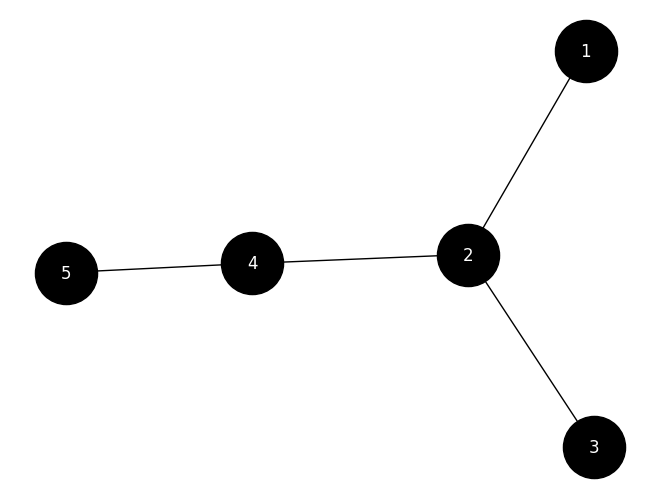

In [3]:
network = Network(nodes=[1, 2, 3, 4, 5],
                  edges=[(1, 2), (2, 3), (2, 4), (4, 5)])

network.plot()

Let's calculate the Laplacian

In [4]:
L = nx.laplacian_matrix(network.G).toarray()
L

array([[ 1, -1,  0,  0,  0],
       [-1,  3, -1, -1,  0],
       [ 0, -1,  1,  0,  0],
       [ 0, -1,  0,  2, -1],
       [ 0,  0,  0, -1,  1]])

Let's double check this is $D - A$ by calculating each and taking the subraction

In [5]:
# Adjacency matrix
A = nx.adjacency_matrix(network.G).toarray()
A

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [6]:
# Degree matrix
D = np.eye(network.G.number_of_nodes(), dtype=np.int32) * [node[1] for node in network.G.degree]
D

array([[1, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1]])

In [7]:
# They are the same!
assert np.array_equal(L, D - A)
D - A, L

(array([[ 1, -1,  0,  0,  0],
        [-1,  3, -1, -1,  0],
        [ 0, -1,  1,  0,  0],
        [ 0, -1,  0,  2, -1],
        [ 0,  0,  0, -1,  1]]),
 array([[ 1, -1,  0,  0,  0],
        [-1,  3, -1, -1,  0],
        [ 0, -1,  1,  0,  0],
        [ 0, -1,  0,  2, -1],
        [ 0,  0,  0, -1,  1]]))

In [8]:
# Let's define our differential equation (assume k=1 here)
dy_dt = lambda L, y: -L.dot(y)

Now, let's assign some temperatures to our nodes! This is our $y$ vector. These are the initial temperatures. Over time they change, but to know how they will change, we need to solve these coupled differential equations.

In [9]:
y0 = [1, 4, 2, 8, 4]
dydt = dy_dt(L, y0)
# Confirm sum of dy_dt vector is 0
sum(dydt)

0

In [10]:
dydt

array([ 3, -1,  2, -8,  4])

Node 2 has a value of -1! This means its temperature will decrease over time. It's neighbors (nodes 1, 3, and 4) have temperatures 1, 2, and 8. The average of these temperatures is ~3.6 which is less than 4 (the temperature of node 2).

OK. So how exactly do we solve for temperature over time?


$\frac{d\vec{y}}{dt} = - k L \vec{y}$

We are dealing with a system of _N_ coupled linear differential equations. To see this, just look at the first component:

$\frac{dy_1}{dt} = -k \sum_j L_{1j} y_j$

You see how it depends in general on the value of all other $y$ components? This is what makes it coupled.

Let's clean up our notation a bit to make this succinct. Let $A = -kL$. This avoids having to carry these constants around. We have:

$y' = A y$

So how do we solve a system of coupled linear equations? One approach is to change the current coordinate system to a new coordinate system such that the equations become uncoupled. We want something like this:

$z' = D z$

Where D is a diagonal matrix (this makes it decoupled). Cool. But how do we get this? The _first_ trick is to rewrite A as:

$A = PDP^{-1}$

Where $D$ is a diagonal matrix and $P$ is just some matrix. The _second_ trick is to apply the following linear transformation to our vector:

$z = P^{-1} y$

Now let's take the derivative and rewrite $y'$

$z' = P^{-1} y' = P^{-1} A y = P^{-1}PDP^{-1}y$

You can see all the rewrites in action. $P^{-1}P$ is the identity matrix so we get left with:

$z' = DP^{-1}y$

But we can apply another rewrite since $P^{-1}y = z$

$z' = Dz$

This is decoupled! What do we do next? Let's look at its first component:

$\frac{dz_1}{dt} = D_{11} z_1$

This is a simple ordinary differential equation and the solution is:

$z_1(t) = z_1(t=0) e^{D_{11} t}$

We can vectorize this:

$z = e^{\lambda t} z_0$

Where $\lambda$ is the vector that holds all of the diagonal entries.


Great. But $z$ is a means to an end. The end is $y$. Let's get that:

$z = P^{-1} y \rightarrow Pz = PP^{-1} y \rightarrow Pz = y$

So we get:

$y = Pz = P e^{\lambda t} (P^{-1} y_0)$

Ok, so this works. But how we even obtain this matrix factorization? Let's dig into this.

$A = PDP^{-1}$

$AP = PD$

or

$AP = DP$

And this gives us:

$A [\vec{v_1} \; \vec{v_2} ... ] = D [\vec{v_1} \; \vec{v_2} ... ]$

So this defines the following equations:

$Av_1 = \lambda_1 v_1$

$Av_2 = \lambda_2 v_2$

...

$Av_N = \lambda_N v_N$

These system of linear algebra equations get some special names. The scaler values get the name eigenvalue and the $v$ vectors get the name eigenvectors. I believe historically, this is exactly where they arose from. From trying to solve a problem of coupled differential equations.


Let's write down our algorithm to summarize:

#### Step 1
Compute the Laplacian: $L = D - A$

#### Step 2
Compute the eigendecomposition $-Lk = PDP^{-1}$

#### Step 3
Compute $z_0 = P^{-1}y_0$

#### Step 4
Compute $y = P e^{\lambda t} z_0$

Let's implement this all into a class. Also, a few things to say before we do:

* When calculating eigenvectors, the vectors length is always 1. This is by design. Different choices of length leads to different eigenvalues. So the convention is to choose a length of 1

* All eigenvectors with distinct eigenvalues are orthogonal to each other (see <a href="https://math.stackexchange.com/questions/142645/are-all-eigenvectors-of-any-matrix-always-orthogonal">here</a> for a discussion about this. It applies to symmetric matrices)

In [11]:
class GraphDiffusion():
    def __init__(self, network, k=1.):
        self.G = network.G
        self.k = k
        self.A = nx.adjacency_matrix(self.G).toarray()
        self.A_λ, self.A_P = np.linalg.eig(self.A)
        
    def fit(self, y0):
        self.y0 = np.array(y0)
        self.L = nx.laplacian_matrix(self.G).toarray()
        self.λ, self.P = np.linalg.eig(-self.k * self.L)
        self.P_ = np.linalg.inv(self.P)
        self.z0 = self.P_.dot(y0)
        
        self.__predict = lambda t: self.P.dot(np.exp(self.λ * t) * self.z0)

    def predict(self, t):
        if np.isscalar(t):
            y = self.__predict(t)
        else:
            y = np.array([self.__predict(ti) for ti in t])
        return y
    
    def __repr__(self):        
        # Removes starting indentations(s)
        return f"""
k          = {round(self.k, 3)}
z0         = {self.z0.round(3)}
y0         = {self.y0.round(3)}
E[y0]      = {np.mean(y0).round(3)}
yf         = {self.predict(1e9).round(3)}
A_λ        = {self.A_λ.round(3)}
λ          = {self.λ.round(3)}
A          =
{self.A.round(3)}
A_P        =
{self.A_P.round(3)}
P          =
{self.P.round(3)}
v1.dot(v2) = {self.P[:,0].dot(self.P[:,1])}
v1.dot(v3) = {self.P[:,0].dot(self.P[:,2])}
v2.dot(v3) = {self.P[:,1].dot(self.P[:,2])}
"""

    def plot(self, t, y):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        
        for j in range(self.G.number_of_nodes()):
            ax.plot(t, y[:,j], label=f"{j + 1}", marker='o', markersize=2)

        ax.legend()
        #ax1.set_title(f"y_final = {y[-1,:]} \n mean(y0) = {np.mean(self.y0)}")
        ax.set_ylabel("Temperature")
        ax.set_xlabel("Time (s)")
        plt.show()

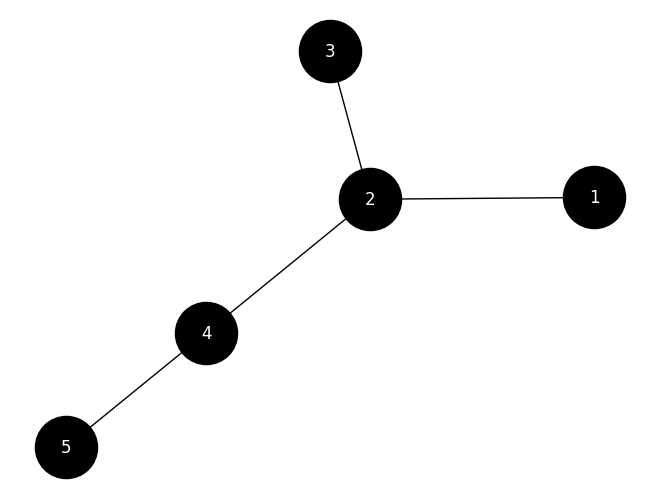

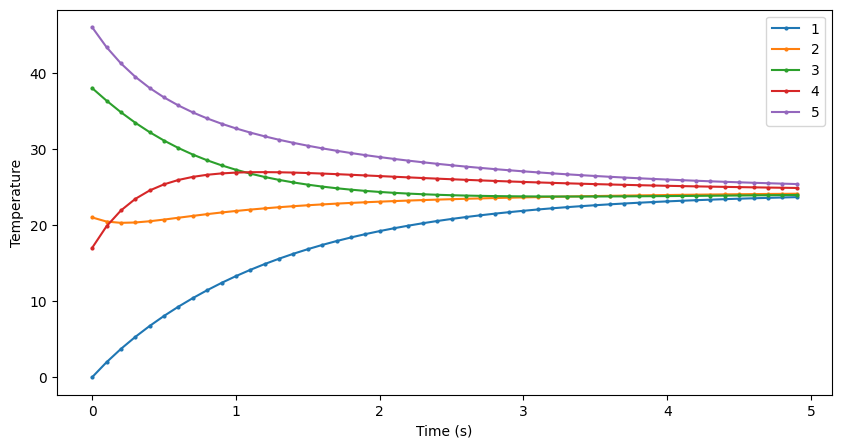


k          = 1
z0         = [  6.224 -15.25   54.56  -26.87   17.886]
y0         = [ 0 21 38 17 46]
E[y0]      = 24.4
yf         = [24.4 24.4 24.4 24.4 24.4]
A_λ        = [-1.848  1.848 -0.765 -0.     0.765]
λ          = [-4.17  -2.311  0.    -1.    -0.519]
A          =
[[0 1 0 0 0]
 [1 0 1 1 0]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 0 0 1 0]]
A_P        =
[[ 0.354  0.354 -0.354  0.707 -0.354]
 [-0.653  0.653  0.271  0.    -0.271]
 [ 0.354  0.354 -0.354 -0.707 -0.354]
 [ 0.5    0.5    0.5    0.     0.5  ]
 [-0.271  0.271 -0.653  0.     0.653]]
P          =
[[-0.256 -0.242  0.447  0.707 -0.419]
 [ 0.811  0.318  0.447  0.    -0.202]
 [-0.256 -0.242  0.447 -0.707 -0.419]
 [-0.438  0.703  0.447 -0.     0.338]
 [ 0.138 -0.536  0.447 -0.     0.702]]
v1.dot(v2) = 1.5265566588595902e-16
v1.dot(v3) = -3.608224830031759e-16
v2.dot(v3) = -1.6653345369377348e-16

In [12]:
nodes=[1, 2, 3, 4, 5]
edges=[(1, 2), (2, 3), (2, 4), (4, 5)]

network = Network(nodes, edges)
gd = GraphDiffusion(network, k=1)

y0 = np.random.randint(0, 50, size=(len(nodes),))
gd.fit(y0)

t = np.arange(start=0, stop=5, step=0.1)
y = gd.predict(t)

network.plot()
gd.plot(t, y)
gd

### Observations

* Final temperature is the average of all initital temperatures
* Two eigenvalues are integer: 0 and -1.
* Eigenvectors seem to be orthogonal
* One zero eigenvalue and one graph component
* The eigenvector associated with the 0 eigenvalue is full of constants (0.447)

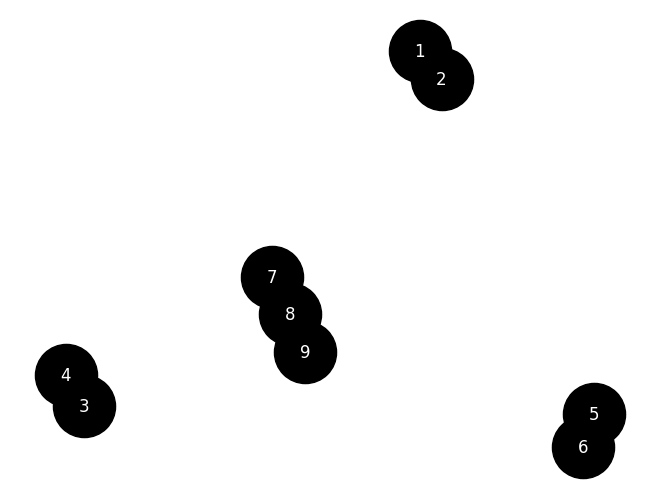

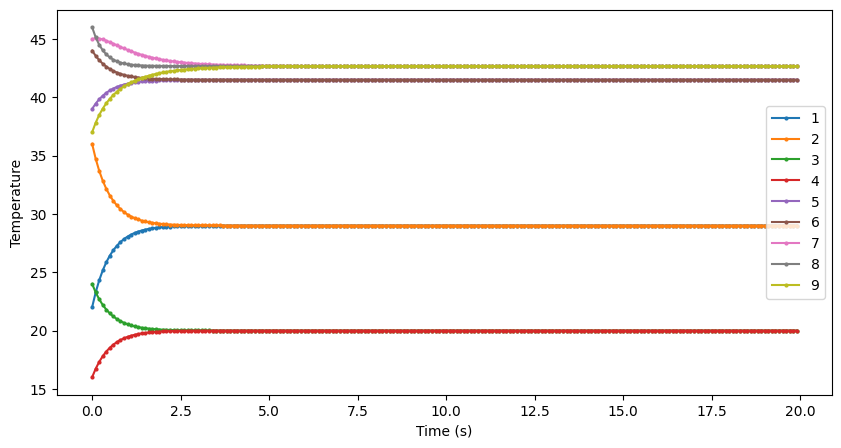


k          = 1.0
z0         = [41.012  9.899 28.284 -5.657 58.69   3.536 -4.082  5.657 73.901]
y0         = [22 36 24 16 39 44 45 46 37]
E[y0]      = 34.333
yf         = [29.    29.    20.    20.    41.5   41.5   42.667 42.667 42.667]
A_λ        = [ 1.    -1.     1.    -1.     1.    -1.    -1.414  0.     1.414]
λ          = [ 0. -2.  0. -2.  0. -2. -3. -1.  0.]
A          =
[[0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 1 0]]
A_P        =
[[ 0.707 -0.707  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.707  0.707  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.707 -0.707  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.707  0.707  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.707 -0.707  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.707  0.707  0.     0.     0.   ]
 [ 0.     0.     0.    

In [13]:
nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
edges = [(1, 2), (3, 4), (5, 6), (7, 8), (8, 9)]
network = Network(nodes, edges)
gd = GraphDiffusion(network)

y0 = np.random.randint(0, 50, size=(len(nodes),))
gd.fit(y0)
t = np.arange(start=0, stop=20, step=0.1)
y = gd.predict(t)
network.plot()
gd.plot(t, y)
print(gd)

### Observations

- All eigenvalues are integer
- 4 zero eigenvalues and 4 graph components
- The eigenvectors with 0 eigenvalues repeat the same number (within the block)
- A block diagonal emerges, where the number of blocks equal the number of components
- The size of each block tells us how many nodes are in the component

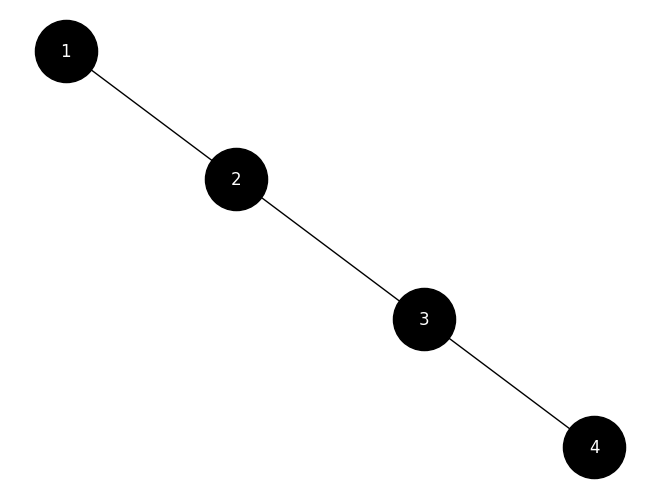

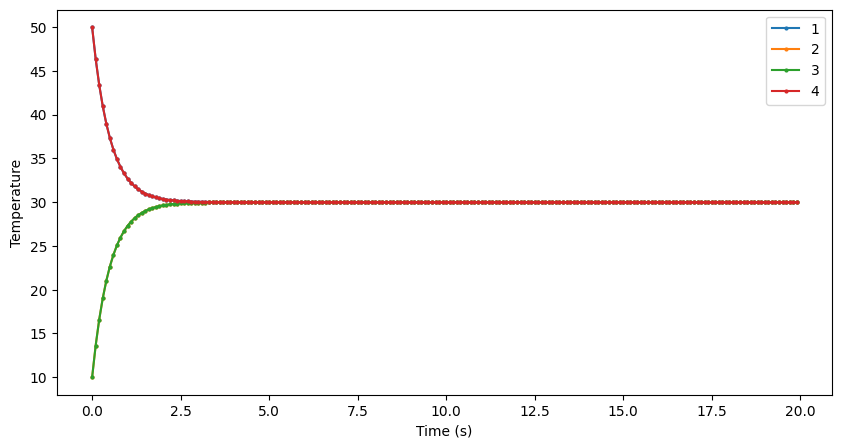


k          = 1.0
z0         = [  0. -40. -60.   0.]
y0         = [50 10 10 50]
E[y0]      = 30.0
yf         = [30. 30. 30. 30.]
A_λ        = [-1.618 -0.618  1.618  0.618]
λ          = [-3.414 -2.    -0.    -0.586]
A          =
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
A_P        =
[[ 0.372  0.602 -0.372 -0.602]
 [-0.602 -0.372 -0.602 -0.372]
 [ 0.602 -0.372 -0.602  0.372]
 [-0.372  0.602 -0.372  0.602]]
P          =
[[-0.271 -0.5   -0.5   -0.653]
 [ 0.653  0.5   -0.5   -0.271]
 [-0.653  0.5   -0.5    0.271]
 [ 0.271 -0.5   -0.5    0.653]]
v1.dot(v2) = -2.220446049250313e-16
v1.dot(v3) = 1.6653345369377348e-16
v2.dot(v3) = 5.551115123125783e-17



In [14]:
nodes=[1, 2, 3, 4]
edges=[(1, 2), (2, 3), (3, 4)]

network = Network(nodes, edges)
gd = GraphDiffusion(network)

y0 = [50, 10, 10, 50]
gd.fit(y0)
t = np.arange(start=0, stop=20, step=0.1)
y = gd.predict(t)
network.plot()
gd.plot(t, y)
print(gd)

### Observations
- Two integer eigenvalues: -2, 0
- The eigenvector paried with the 0 eigenvalue repeats the same number (-0.5)
- One zero eigenvalue and one graph component

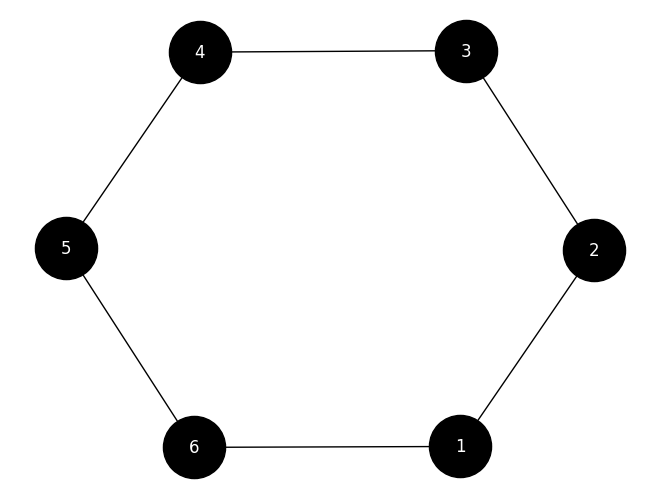

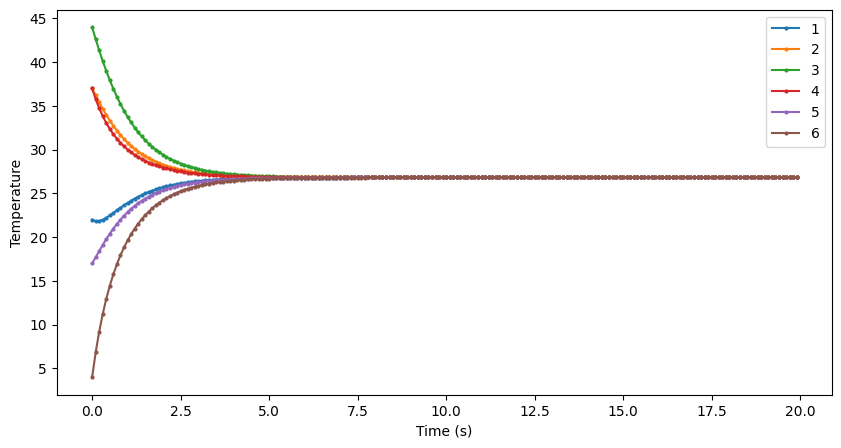


k          = 1.0
z0         = [-65.728  13.691   2.041  -3.489   3.206  30.009]
y0         = [22 37 44 37 17  4]
E[y0]      = 26.833
yf         = [26.833 26.833 26.833 26.833 26.833 26.833]
A_λ        = [-2.  2.  1. -1. -1.  1.]
λ          = [ 0. -1. -4. -3. -3. -1.]
A          =
[[0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 0]]
A_P        =
[[ 0.408 -0.408 -0.577  0.577  0.066  0.098]
 [-0.408 -0.408 -0.289 -0.294 -0.53  -0.444]
 [ 0.408 -0.408  0.289 -0.284  0.464 -0.542]
 [-0.408 -0.408  0.577  0.577  0.066 -0.098]
 [ 0.408 -0.408  0.289 -0.294 -0.53   0.444]
 [-0.408 -0.408 -0.289 -0.284  0.464  0.542]]
P          =
[[-0.408 -0.577  0.408 -0.577  0.204 -0.014]
 [-0.408 -0.289 -0.408  0.289  0.366  0.493]
 [-0.408  0.289  0.408  0.289 -0.57   0.507]
 [-0.408  0.577 -0.408 -0.577  0.204  0.014]
 [-0.408  0.289  0.408  0.289  0.366 -0.493]
 [-0.408 -0.289 -0.408  0.289 -0.57  -0.507]]
v1.dot(v2) = -8.049116928532385e-16
v1.dot(v3) = -1.6653345

In [15]:
nodes = [1, 2, 3, 4, 5, 6]
edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]

network = Network(nodes, edges)
gd = GraphDiffusion(network)

y0 = np.random.randint(0, 50, size=(len(nodes),))
gd.fit(y0)
t = np.arange(start=0, stop=20, step=0.1)
y = gd.predict(t)
network.plot()
gd.plot(t, y)
print(gd)

### Observations
* All integer eigenvalues
* The eigenvector paired with the 0 eigenvalue repeats the same number (-0.408)
* One zero eigenvalue and one graph component

OK. From our observations, let's make some hypotheses:

* The multiplicity of the 0 eigenvalue equals the number of components in the graph
* Every eigenvector paired with a 0 eigenvalue repeats the same number
* The P matrix seems to be a block matrix where each block equals the number of components in the graph
* The size of each block in P tells us how many nodes are in that component


More exploration is needed to confirm these hypotheses....

# Reading List

These articles were inspiring and helpful when writing this article:

1. https://www.maa.org/press/periodicals/convergence/math-origins-eigenvectors-and-eigenvalues
2. http://www.math.utah.edu/~gustafso/2250Eigenanalysis.pdf
3. https://cecs.wright.edu/~sthomas/htchapter02.pdf
4. https://www.math.fsu.edu/~bertram/lectures/Diffusion.pdf
5. https://mbernste.github.io/posts/laplacian_matrix/